## 安裝套件

In [1]:
!pip install requests

In [2]:
!pip install feedparser

In [3]:
!pip install lxml

In [4]:
!pip install jieba

### 下載繁體字的辭典檔

In [5]:
!wget https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big -O jieba_data/dict.txt.big

--2022-11-06 16:04:15--  https://github.com/fxsjy/jieba/raw/master/extra_dict/dict.txt.big
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/fxsjy/jieba/master/extra_dict/dict.txt.big [following]
--2022-11-06 16:04:15--  https://raw.githubusercontent.com/fxsjy/jieba/master/extra_dict/dict.txt.big
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8583143 (8.2M) [text/plain]
Saving to: ‘jieba_data/dict.txt.big’

jieba_data/dict.txt 100%[===================>]   8.18M  8.10MB/s    in 1.0s    

2022-11-06 16:04:16 (8.10 MB/s) - ‘jieba_data/dict.txt.big’ saved [8583143/8583143]



In [6]:
!pip install wordcloud

## 解析 RSS

In [7]:
import feedparser

In [8]:
rss_url = "https://money.udn.com/rssfeed/news/1001/5588/10511?ch=money"

In [9]:
newsFeed = feedparser.parse(rss_url)
newsFeed

{'bozo': False,
 'entries': [{'title': '舊金山矽谷台人參政 不讓亞裔變「啞」裔',
   'title_detail': {'type': 'text/plain',
    'language': None,
    'base': 'https://money.udn.com/rssfeed/news/1001/5588/10511?ch=money',
    'value': '舊金山矽谷台人參政 不讓亞裔變「啞」裔'},
   'links': [{'rel': 'alternate',
     'type': 'text/html',
     'href': 'https://money.udn.com/money/story/10511/6743287'}],
   'link': 'https://money.udn.com/money/story/10511/6743287',
   'published': 'Sun, 06 Nov 2022 12:00:33 +0800',
   'published_parsed': time.struct_time(tm_year=2022, tm_mon=11, tm_mday=6, tm_hour=4, tm_min=0, tm_sec=33, tm_wday=6, tm_yday=310, tm_isdst=0),
   'summary': '美國期中選',
   'summary_detail': {'type': 'text/html',
    'language': None,
    'base': 'https://money.udn.com/rssfeed/news/1001/5588/10511?ch=money',
    'value': '美國期中選'},
   'id': 'https://money.udn.com/money/story/10511/6743287',
   'guidislink': False},
  {'title': '期中選舉倒數 拜登歐巴馬川普赴戰場州賓州輔選',
   'title_detail': {'type': 'text/plain',
    'language': None,
    '

### 查看每個 entry 的 title, url 

In [10]:
i = 1
for e in newsFeed['entries']:
    title = e['title']
    link_url = e['links'][0]['href']
    print("%s, %s, %s"%(i, title, link_url))
    i = i + 1

1, 舊金山矽谷台人參政 不讓亞裔變「啞」裔, https://money.udn.com/money/story/10511/6743287
2, 期中選舉倒數 拜登歐巴馬川普赴戰場州賓州輔選, https://money.udn.com/money/story/10511/6743179
3, 確保各國持續挺烏 美傳私下勸基輔釋出談判訊號, https://money.udn.com/money/story/10511/6743159
4, 美國會議員挺台 候選人互指親中抹紅變口水戰, https://money.udn.com/money/story/10511/6743029
5, 紐約台裔選將輩出  老鳥拚連任新人爭出線, https://money.udn.com/money/story/10511/6742983
6, 白宮：美中官員仍在努力安排G20拜習會, https://money.udn.com/money/story/10511/6732419
7, 美中外長通話70分鐘 國務院回應北京：無意扯中國大陸後腿, https://money.udn.com/money/story/10511/6729572
8, 戴琪：二十大後 美中關係觀望中, https://money.udn.com/money/story/10511/6724956


### 解析html可以參考 https://lxml.de/lxmlhtml.html

## 開始取得文章

### 載入 library

In [11]:
import requests
from lxml import etree
from io import StringIO
import jieba
import pandas as pd
import time
import random

### 使用繁體辭典

In [12]:
#指定辭典檔
jieba.set_dictionary('jieba_data/dict.txt.big')

### 設定 request header

In [13]:
#設定 request header
user_agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36"
my_headers = {
    'User-Agent': user_agent,
    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8",
    "accept-Language": "zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7",
    "accept-encoding": "gzip, deflate, br",
    "Connection": "keep-alive",
    "cache-control": "no-cache",
    "Accept-Charset": "UTF8,utf-8;q=0.7,*;q=0.7"
}

### 先爬文

In [14]:
#分解動作

#爬文
each_article_text_list = []
for e in newsFeed['entries']:
    url = e['links'][0]['href']
    print(url)
    r = requests.get(url, headers = my_headers)
    if r.status_code == 200:
        parse_tree = etree.parse(StringIO(r.text), etree.HTMLParser())
        article_elements = parse_tree.xpath('//*[@id="article_body"]//p')
        for a_part in article_elements:
            if type(a_part.text) is str:
                each_article_text_list.append(a_part.text.strip())
        sleep_time = random.randint(3,10)
        print("sleep time: %s sec"%(sleep_time))
        time.sleep(sleep_time)
    all_article_text = ''.join(each_article_text_list)
all_article_text

https://money.udn.com/money/story/10511/6743287
sleep time: 9 sec
https://money.udn.com/money/story/10511/6743179
sleep time: 7 sec
https://money.udn.com/money/story/10511/6743159
sleep time: 8 sec
https://money.udn.com/money/story/10511/6743029
sleep time: 3 sec
https://money.udn.com/money/story/10511/6742983
sleep time: 9 sec
https://money.udn.com/money/story/10511/6732419
sleep time: 9 sec
https://money.udn.com/money/story/10511/6729572
sleep time: 7 sec
https://money.udn.com/money/story/10511/6724956
sleep time: 6 sec


'美國期中選舉（中央社記者周世惠舊金山5日專電）美國期中選舉8日投票，在地方選戰中，加州矽谷至少有6位具有台灣背景的候選人，台裔參政最積極的城市是蘋果公司總部所在的古柏迪諾（Cupertino）。舊金山灣區的台僑組織「古柏迪諾台中友誼城市協會」4日晚間透過線上形式，邀請台裔候選人開講，鼓勵移民社區的民眾投票表達聲音。尋求連任的古柏迪諾副市長趙良方（Liang FangChao）說，只有積極參與公民活動，亞裔在美國才不會被人忽視為「啞」裔。趙良方在台北出生、幼時住過花蓮，父母是軍醫與護士。她自北一女中、交通大學畢業後，赴美留學獲普林斯頓大學博士，曾任教職與工程師。趙良方提到，台灣是故鄉，每次參加僑界國慶雙十活動，唱國歌、國旗歌時覺得感動。她說自己從「內向理工女」、學生家長，轉成民選官員，在矽谷的從政歷程是從學區委員到市議會。角逐學區委員幾乎是政治素人在美國參政的第一步。在加州，各學區委員會負責公立學校教材審查、監管約數百萬美元的財政等。古柏迪諾今年有3位台裔人士競選中小學區委員。現任古柏迪諾市長的蒲仲辰（Darcy Paul）擔任副市長與市長多年後，轉投入競選學區委員，關注COVID-19（2019冠狀病毒疾病）疫情後的教育問題。蒲仲辰畢業於哈佛大學法學院，得過州際盃游泳冠軍，父親蒲大宏1980年代在台著作托福英語教程聞名。他自述從台灣移民的父母身上學到克勤克儉及自律；他的妻子畢業於北一女和台灣大學，他哥哥是70年代長跑小將蒲仲強（Wesley Paul）、也是哈佛大學畢業的執業律師。另一位是尋求連任的中小學區委員劉錦宗（JerryLiu），當年他父母獲得抽籤移民的機會，來美國時他是一句英文也不會的小學生，看著父母辛苦打工，他一路念到康乃爾大學畢業。自己孩子在公立學校就讀，劉錦宗工作之餘，從關心教育而參與社區服務。擔任教師近20年的喬百琪（Ava Chiao）首次參選古柏迪諾市中小學區委員，她的雙親在台灣是大學畢業生，移民美國改行當廚師和銀行行員。她童年的週末全家在跳蚤市場賣玩具，直到父母開了自己的餐館。過去熱心僑界中文學校教育的寇惠風（StanleyHuey-Feng Kou）競選舊金山南灣佛利蒙特聯合高中學區（FUHSD）學區委員。這個學區有5所矽谷排名高的公立高中，學區委員會目前沒有台裔或華人，他出馬角逐受到矚目。位在舊金山東灣、電動車特斯拉工廠所在的佛利蒙特（

### 做分詞

In [15]:
#分詞
seg_words_list = jieba.lcut(all_article_text)
seg_words_list

Building prefix dict from /home/jovyan/work/Text_wordcloud/jieba_data/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u240ff8c1e70462be159af457c3f6d652.cache
Loading model cost 2.816 seconds.
Prefix dict has been built successfully.


['美國',
 '期中',
 '選舉',
 '（',
 '中央社',
 '記者',
 '周世惠',
 '舊金山',
 '5',
 '日',
 '專電',
 '）',
 '美國',
 '期中',
 '選舉',
 '8',
 '日',
 '投票',
 '，',
 '在',
 '地方',
 '選戰',
 '中',
 '，',
 '加州',
 '矽谷',
 '至少',
 '有',
 '6',
 '位',
 '具有',
 '台灣',
 '背景',
 '的',
 '候選人',
 '，',
 '台裔',
 '參政',
 '最',
 '積極',
 '的',
 '城市',
 '是',
 '蘋果公司',
 '總部',
 '所在',
 '的',
 '古柏迪諾',
 '（',
 'Cupertino',
 '）',
 '。',
 '舊金山灣',
 '區的',
 '台僑',
 '組織',
 '「',
 '古柏迪諾台',
 '中',
 '友誼',
 '城市',
 '協會',
 '」',
 '4',
 '日',
 '晚間',
 '透過',
 '線上',
 '形式',
 '，',
 '邀請',
 '台裔',
 '候選人',
 '開講',
 '，',
 '鼓勵',
 '移民',
 '社區',
 '的',
 '民眾',
 '投票',
 '表達',
 '聲音',
 '。',
 '尋求',
 '連任',
 '的',
 '古柏迪諾',
 '副',
 '市長',
 '趙',
 '良方',
 '（',
 'Liang',
 ' ',
 'FangChao',
 '）',
 '說',
 '，',
 '只有',
 '積極',
 '參與',
 '公民',
 '活動',
 '，',
 '亞裔',
 '在',
 '美國',
 '才',
 '不會',
 '被',
 '人',
 '忽視',
 '為',
 '「',
 '啞',
 '」',
 '裔',
 '。',
 '趙',
 '良方',
 '在',
 '台北',
 '出生',
 '、',
 '幼時',
 '住過',
 '花蓮',
 '，',
 '父母',
 '是',
 '軍醫',
 '與',
 '護士',
 '。',
 '她',
 '自',
 '北一女',
 '中',
 '、',
 '交通',
 '大學畢業',
 '後',
 '，',
 '赴美',
 '留學',
 '獲',


In [16]:
!ls jieba_data

dict.txt.big  mydict.txt  stop_words.txt


### 準備 stop word

In [17]:
#stop word
with open(file='jieba_data/stop_words.txt', mode='r', encoding='utf-8') as file:
    stop_words = file.read().split('\n')
stop_words

['the',
 'of',
 'is',
 'and',
 'to',
 'in',
 'that',
 'we',
 'for',
 'an',
 'are',
 'by',
 'be',
 'as',
 'on',
 'with',
 'can',
 'if',
 'from',
 'which',
 'you',
 'it',
 'this',
 'then',
 'at',
 'have',
 'all',
 'not',
 'one',
 'has',
 'or',
 'that',
 '的',
 '了',
 '和',
 '是',
 '就',
 '都',
 '而',
 '及',
 '與',
 '著',
 '或',
 '一個',
 '沒有',
 '我們',
 '你們',
 '妳們',
 '他們',
 '她們',
 '是否',
 '(',
 ')',
 '[',
 ']',
 '《',
 '》',
 '；',
 '『',
 '』',
 '：',
 ' ',
 '’',
 '（',
 '）',
 '、',
 '」',
 '「',
 '。',
 '，',
 '在',
 '他',
 '日',
 '對',
 '']

### 準備一個利用stop word過濾後的分詞結果

In [18]:
#分詞
seg_stop_words_list = []
seg_words_list = jieba.lcut(all_article_text)
for term in seg_words_list:
    if term not in stop_words:
        seg_stop_words_list.append(term)
seg_stop_words_list

['美國',
 '期中',
 '選舉',
 '中央社',
 '記者',
 '周世惠',
 '舊金山',
 '5',
 '專電',
 '美國',
 '期中',
 '選舉',
 '8',
 '投票',
 '地方',
 '選戰',
 '中',
 '加州',
 '矽谷',
 '至少',
 '有',
 '6',
 '位',
 '具有',
 '台灣',
 '背景',
 '候選人',
 '台裔',
 '參政',
 '最',
 '積極',
 '城市',
 '蘋果公司',
 '總部',
 '所在',
 '古柏迪諾',
 'Cupertino',
 '舊金山灣',
 '區的',
 '台僑',
 '組織',
 '古柏迪諾台',
 '中',
 '友誼',
 '城市',
 '協會',
 '4',
 '晚間',
 '透過',
 '線上',
 '形式',
 '邀請',
 '台裔',
 '候選人',
 '開講',
 '鼓勵',
 '移民',
 '社區',
 '民眾',
 '投票',
 '表達',
 '聲音',
 '尋求',
 '連任',
 '古柏迪諾',
 '副',
 '市長',
 '趙',
 '良方',
 'Liang',
 'FangChao',
 '說',
 '只有',
 '積極',
 '參與',
 '公民',
 '活動',
 '亞裔',
 '美國',
 '才',
 '不會',
 '被',
 '人',
 '忽視',
 '為',
 '啞',
 '裔',
 '趙',
 '良方',
 '台北',
 '出生',
 '幼時',
 '住過',
 '花蓮',
 '父母',
 '軍醫',
 '護士',
 '她',
 '自',
 '北一女',
 '中',
 '交通',
 '大學畢業',
 '後',
 '赴美',
 '留學',
 '獲',
 '普林斯頓大學',
 '博士',
 '曾',
 '任教',
 '職與',
 '工程師',
 '趙',
 '良方',
 '提到',
 '台灣',
 '故鄉',
 '每次',
 '參加',
 '僑界',
 '國慶',
 '雙十',
 '活動',
 '唱國歌',
 '國旗歌',
 '時',
 '覺得',
 '感動',
 '她',
 '說',
 '自己',
 '從',
 '內向',
 '理工',
 '女',
 '學生家長',
 '轉成',
 '民選',
 '官員',
 '矽谷',


In [19]:
#合併動作 XD
each_article_text_list = []
seg_words_list = []
for e in newsFeed['entries']:
    url = e['links'][0]['href']
    print(url)
    r = requests.get(url, headers = my_headers)
    if r.status_code == 200:
        parse_tree = etree.parse(StringIO(r.text), etree.HTMLParser())
        article_elements = parse_tree.xpath('//article//p')
        for a_part in article_elements:
            if type(a_part.text) is str:
                term = a_part.text.strip()
                if term not in stop_words:
                    each_article_text_list.append(term)
        all_article_text += ''.join(each_article_text_list)
        sleep_time = random.randint(3,10)
        print("sleep time: %s sec"%(sleep_time))
        time.sleep(sleep_time)
seg_words_list = jieba.lcut(all_article_text)
seg_df = pd.DataFrame(seg_words_list, columns=['seg_word'])
print(seg_df)

https://money.udn.com/money/story/10511/6743287
sleep time: 8 sec
https://money.udn.com/money/story/10511/6743179
sleep time: 4 sec
https://money.udn.com/money/story/10511/6743159
sleep time: 4 sec
https://money.udn.com/money/story/10511/6743029
sleep time: 8 sec
https://money.udn.com/money/story/10511/6742983
sleep time: 4 sec
https://money.udn.com/money/story/10511/6732419
sleep time: 9 sec
https://money.udn.com/money/story/10511/6729572
sleep time: 5 sec
https://money.udn.com/money/story/10511/6724956
sleep time: 4 sec
      seg_word
0           美國
1           期中
2           選舉
3            （
4          中央社
...        ...
23136        ，
23137       請勿
23138       複製
23139       轉貼
23140     文章內容

[23141 rows x 1 columns]


### 載入繪圖相關的 library

In [20]:
import matplotlib
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
print(matplotlib.matplotlib_fname())

/opt/conda/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc


### 安裝中文字型

In [21]:
!ls fonts/*.ttf

fonts/SimHei.ttf  fonts/TaipeiSansTCBeta-Regular.ttf


In [22]:
#!cat /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/matplotlibrc

#### 字型檔案是放在 /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf 我們先列出來看一下

In [23]:
!ls /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf

ls: cannot access '/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf': No such file or directory


#### 將中文字型檔案放到字型收容的路徑

In [24]:
!cp fonts/*.ttf /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf 

cp: target '/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf' is not a directory


#### 檢查一下結果

In [25]:
!ls /opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf

ls: cannot access '/opt/conda/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf': No such file or directory


#### 清除 matplotlib 快取

In [26]:
print(matplotlib.get_configdir())

/home/jovyan/.config/matplotlib


In [27]:
!ls -la /home/jovyan/.config/matplotlib

total 8
drwsrwsr-x 2 jovyan users 4096 Mar 15  2022 .
drwsrwsr-x 3 jovyan users 4096 Mar 15  2022 ..


In [28]:
print(matplotlib.get_cachedir())

/home/jovyan/.cache/matplotlib


In [29]:
!rm -rf /home/jovyan/.cache/matplotlib

In [30]:
#用來顯示中文
plt.rcParams['font.sans-serif']=['SimHei']
#用來顯示負號
plt.rcParams['axes.unicode_minus']=False

#### 其他 FAQ 可以參考 https://matplotlib.org/3.1.1/faq/troubleshooting_faq.html

### 繪製文字雲 ( wordcloud.generate )

In [31]:
# wordcloud.generate 參數是吃文字內容，以空白為文字區隔
seg_words = ' '.join(seg_words_list)
#seg_words

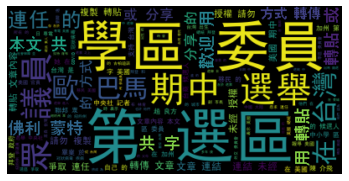

In [32]:
#不同字型
wordcloud = WordCloud(font_path='fonts/SimHei.ttf').generate(seg_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

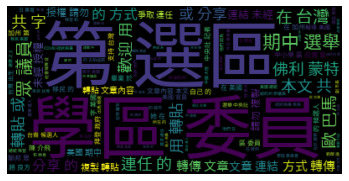

In [33]:
#不同字型
wordcloud = WordCloud(font_path='fonts/TaipeiSansTCBeta-Regular.ttf').generate(seg_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 繪製文字雲 ( wordcloud.generate_from_frequencies )

In [34]:
# https://docs.python.org/zh-tw/3/library/collections.html
# 準備一個沒有經過stop word 處理的 counter
from collections import Counter
seg_counter = Counter(seg_words_list)
seg_counter

Counter({'美國': 243,
         '期中': 48,
         '選舉': 75,
         '（': 346,
         '中央社': 37,
         '記者': 35,
         '周世惠': 9,
         '舊金山': 27,
         '5': 42,
         '日': 80,
         '專電': 20,
         '）': 346,
         '8': 58,
         '投票': 31,
         '，': 1474,
         '在': 431,
         '地方': 27,
         '選戰': 26,
         '中': 85,
         '加州': 66,
         '矽谷': 27,
         '至少': 9,
         '有': 49,
         '6': 36,
         '位': 18,
         '具有': 9,
         '台灣': 193,
         '背景': 15,
         '的': 918,
         '候選人': 84,
         '台裔': 76,
         '參政': 18,
         '最': 34,
         '積極': 18,
         '城市': 27,
         '是': 165,
         '蘋果公司': 9,
         '總部': 9,
         '所在': 18,
         '古柏迪諾': 36,
         'Cupertino': 9,
         '。': 719,
         '舊金山灣': 9,
         '區的': 9,
         '台僑': 9,
         '組織': 15,
         '「': 245,
         '古柏迪諾台': 9,
         '友誼': 9,
         '協會': 9,
         '」': 245,
         '4': 17,
         '

In [35]:
# 準備一個有經過stop word 處理的 counter
from collections import Counter
seg_stop_counter = Counter(seg_stop_words_list)
#seg_stop_counter

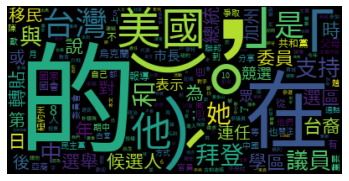

In [36]:
#沒有處理stop words
wordcloud = WordCloud(font_path='fonts/TaipeiSansTCBeta-Regular.ttf').generate_from_frequencies(seg_counter)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

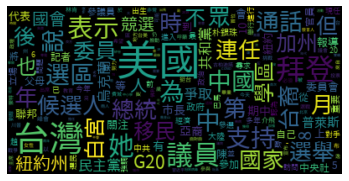

In [37]:
#有處理stop words
wordcloud = WordCloud(font_path='fonts/TaipeiSansTCBeta-Regular.ttf').generate_from_frequencies(seg_stop_counter)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### [其他] 用dataframe 處理數據

In [38]:
seg_df = pd.DataFrame(seg_words_list, columns=['seg_word'])
seg_df

,seg_word
0,美國
1,期中
2,選舉
3,（
4,中央社
...,...
23136,，
23137,請勿
23138,複製
23139,轉貼


In [39]:
seg_df['count'] = 1
seg_freq_df = seg_df.groupby('seg_word').sum()
seg_freq_df

,count
seg_word,
,244
-,31
1,4
10,39
1026,4
...,...
（,346
）,346
，,1474


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12289 (\N{IDEOGRAPHIC COMMA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12290 (\N{IDEOGRAPHIC FULL STOP}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12300 (\N{LEFT CORNER BRACKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12301 (\N{RIGHT CORNER BRACKET}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/conda/lib/python3.9/site-packages/IPython/core/

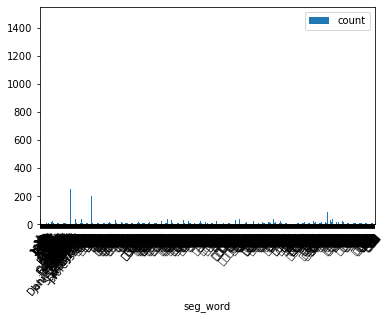

In [40]:
seg_df.groupby('seg_word').sum().plot.bar()
plt.xticks(rotation=50)
plt.show()

### [其他] parse html 小筆記

In [41]:
import requests
from lxml import etree
import jieba
from io import StringIO
import pandas as pd

for e in newsFeed['entries']:
    url = e['links'][0]['href']
    print(url)
    r = requests.get(url)
    #print(r.status_code == 200)
    if r.status_code == 200:
        html_tree = etree.HTML(r.text)
        print(html_tree)
        html_ele = html_tree.xpath('//article//p')
        all_ele = [ (ele.text.strip()) for ele in html_ele if type(ele.text) is str ]
        all_ele_string = ''.join(all_ele)
        seg_words = jieba.lcut(all_ele_string)
        seg_df = pd.DataFrame(seg_words, columns=['seg_word'])
        seg_df['count'] = 1
        print(seg_df)

https://money.udn.com/money/story/10511/6743287
<Element html at 0x7f210cca34c0>
    seg_word  count
0         本文      1
1          共      1
2       1291      1
3          字      1
4         美國      1
..       ...    ...
725        ，      1
726       請勿      1
727       複製      1
728       轉貼      1
729     文章內容      1

[730 rows x 2 columns]
https://money.udn.com/money/story/10511/6743179
<Element html at 0x7f20f9ca66c0>
    seg_word  count
0         本文      1
1          共      1
2        961      1
3          字      1
4         美國      1
..       ...    ...
553        ，      1
554       請勿      1
555       複製      1
556       轉貼      1
557     文章內容      1

[558 rows x 2 columns]
https://money.udn.com/money/story/10511/6743159
<Element html at 0x7f210cce9a40>
    seg_word  count
0         本文      1
1          共      1
2        573      1
3          字      1
4          「      1
..       ...    ...
317        ，      1
318       請勿      1
319       複製      1
320       轉貼      1
321     文